# Phase 1: Data Preparation & Exploratory Data Analysis

This notebook performs comprehensive data exploration and quality assessment for flight event data.

## Objectives
1. Load and explore raw flight event data
2. Assess data quality (missing values, duplicates, validity)
3. Analyze event types, temporal patterns, and spatial distributions
4. Reconstruct flight trajectories from events
5. Identify preliminary anomalies
6. Prepare cleaned data for Phase 2 (Feature Engineering)

## Prerequisites
- Data files downloaded from Google Drive and placed in `data/raw/`
- All dependencies installed (`pip install -r requirements.txt`)


In [1]:
# Setup and Import Libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

# Import project modules
from src.data.data_loader import load_all_data_files, extract_all_zip_files, parse_info_field, extract_info_fields
from src.data.data_quality import (
    check_missing_values, check_duplicates, validate_timestamps,
    validate_coordinates, validate_altitude, generate_quality_report
)
from src.data.flight_reconstruction import (
    reconstruct_flights, create_flight_summary_dataset, 
    add_temporal_features, add_spatial_features
)
from src.utils.helpers import load_config, ensure_dir

print("✓ Libraries imported successfully")
print(f"Project root: {project_root}")


✓ Libraries imported successfully
Project root: c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project


In [2]:
# Configuration and Directory Setup
config = load_config(project_root / 'config' / 'config.yaml')

# Setup directories
raw_dir = project_root / config['data']['raw_dir']
processed_dir = project_root / config['data']['processed_dir']
output_dir = project_root / config['output']['figures_dir']

ensure_dir(processed_dir)
ensure_dir(output_dir)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Configuration loaded")
print(f"Raw data directory: {raw_dir}")
print(f"Processed data directory: {processed_dir}")
print(f"Figures directory: {output_dir}")


✓ Configuration loaded
Raw data directory: c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\raw
Processed data directory: c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed
Figures directory: c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\outputs\figures


## Step 1: Data Loading Instructions

### Download Data

**Training Data**: https://drive.google.com/drive/u/1/folders/1Scvz11KmgIt5dzmSMzS4MCv0IXnte2a-

**Testing Data**: https://drive.google.com/drive/u/1/folders/1l3LtAp0u2svJ46lBL80WwwABz7TllSXF

Place downloaded CSV or ZIP files in: `data/raw/`

The notebook will automatically extract ZIP files if present.


In [3]:
# Load Data
# Automatically extracts ZIP files if present
print("Loading data from raw directory...")
df = load_all_data_files(str(raw_dir), auto_extract_zip=True)

if df is None or len(df) == 0:
    print("❌ No data files found!")
    print(f"Please download data and place in: {raw_dir}")
    raise FileNotFoundError("No data files found in raw directory")

print(f"\n✓ Data loaded successfully!")
print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")


Loading data from raw directory...
Found 2 ZIP file(s), extracting...
Found 2 ZIP file(s)
Extracting testing-20251204T055119Z-1-001.zip...


Extracting: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


✓ Extracted 3 CSV file(s)
Extracting training-20251204T055116Z-1-001.zip...


Extracting: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


✓ Extracted 12 CSV file(s)
Found 15 CSV file(s)


Loading files: 100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


Total records: 9,554,722

✓ Data loaded successfully!
Total records: 9,554,722
Columns: ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'DUP', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST', 'ORIGIN_STATE_ABR', 'DEST_STATE_ABR']


## Step 2: Basic Information

Examine the dataset structure, data types, and sample records.


In [4]:
# Basic dataset information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumn Names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

print(f"\nData Types:")
print(df.dtypes)

print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nLast 5 rows:")
print(df.tail())


DATASET OVERVIEW

Shape: 9,554,722 rows × 49 columns

Column Names:
  1. YEAR
  2. MONTH
  3. DAY_OF_MONTH
  4. DAY_OF_WEEK
  5. FL_DATE
  6. OP_UNIQUE_CARRIER
  7. ORIGIN
  8. ORIGIN_CITY_NAME
  9. ORIGIN_STATE_NM
  10. DEST
  11. DEST_CITY_NAME
  12. DEST_STATE_NM
  13. CRS_DEP_TIME
  14. DEP_TIME
  15. DEP_DELAY
  16. DEP_DELAY_NEW
  17. DEP_DEL15
  18. DEP_DELAY_GROUP
  19. DEP_TIME_BLK
  20. TAXI_OUT
  21. WHEELS_OFF
  22. WHEELS_ON
  23. TAXI_IN
  24. CRS_ARR_TIME
  25. ARR_TIME
  26. ARR_DELAY
  27. ARR_DELAY_NEW
  28. ARR_DEL15
  29. ARR_DELAY_GROUP
  30. ARR_TIME_BLK
  31. CANCELLED
  32. CANCELLATION_CODE
  33. DIVERTED
  34. DUP
  35. CRS_ELAPSED_TIME
  36. ACTUAL_ELAPSED_TIME
  37. AIR_TIME
  38. FLIGHTS
  39. DISTANCE
  40. DISTANCE_GROUP
  41. CARRIER_DELAY
  42. WEATHER_DELAY
  43. NAS_DELAY
  44. SECURITY_DELAY
  45. LATE_AIRCRAFT_DELAY
  46. DIV_AIRPORT_LANDINGS
  47. DIV_REACHED_DEST
  48. ORIGIN_STATE_ABR
  49. DEST_STATE_ABR

Data Types:
YEAR                      in

## Step 3: Missing Values Analysis

Identify and visualize missing values in the dataset.


Missing Values Summary:
                  column  missing_count  missing_percent    dtype
46      DIV_REACHED_DEST        9529784        99.738998  float64
31     CANCELLATION_CODE        9423097        98.622409   object
44   LATE_AIRCRAFT_DELAY        7558675        79.109314  float64
43        SECURITY_DELAY        7558675        79.109314  float64
42             NAS_DELAY        7558675        79.109314  float64
41         WEATHER_DELAY        7558675        79.109314  float64
40         CARRIER_DELAY        7558675        79.109314  float64
48        DEST_STATE_ABR        7020146        73.473053   object
47      ORIGIN_STATE_ABR        7020146        73.473053   object
8        ORIGIN_STATE_NM        2534576        26.526947   object
11         DEST_STATE_NM        2534576        26.526947   object
33                   DUP         582205         6.093375   object
5      OP_UNIQUE_CARRIER         582205         6.093375   object
25             ARR_DELAY         156563         1.63

<Figure size 1200x600 with 0 Axes>

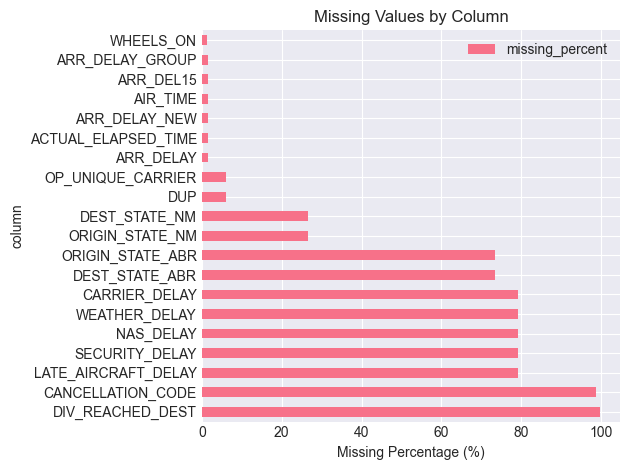

In [5]:
# Check for missing values
missing_stats = check_missing_values(df)

if len(missing_stats) > 0:
    print("Missing Values Summary:")
    print("="*60)
    print(missing_stats.to_string())
    
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    missing_stats.head(20).plot(kind='barh', x='column', y='missing_percent')
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Values by Column')
    plt.tight_layout()
    plt.savefig(output_dir / 'missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("✓ No missing values found!")


## Step 4: Duplicate Records Check

Identify duplicate records in the dataset.


In [7]:
# Check for duplicates
dup_stats_full = check_duplicates(df)

# Only check subset duplicates if all columns exist in the data
subset_cols = ['flight_id', 'timestamp', 'event_type']
available_subset_cols = [c for c in subset_cols if c in df.columns]

dup_stats_subset = None
if len(available_subset_cols) == len(subset_cols):
    dup_stats_subset = check_duplicates(df, subset=available_subset_cols)

print("Duplicate Records:")
print("="*60)
print(f"Full duplicates: {dup_stats_full['n_duplicates']:,} ({dup_stats_full['duplicate_percent']:.2f}%)")

if dup_stats_subset is not None:
    print(f"Subset duplicates ({', '.join(available_subset_cols)}): {dup_stats_subset['n_duplicates']:,} ({dup_stats_subset['duplicate_percent']:.2f}%)")
else:
    print("Subset duplicate check skipped because one or more columns are missing.")

if dup_stats_full['n_duplicates'] > 0:
    print("\n⚠️  Duplicate records found. Consider removing them.")
    df = df.drop_duplicates()
    print(f"✓ Removed duplicates. New shape: {df.shape}")
else:
    print("\n✓ No duplicate records found.")


Duplicate Records:
Full duplicates: 2 (0.00%)
Subset duplicate check skipped because one or more columns are missing.

⚠️  Duplicate records found. Consider removing them.
✓ Removed duplicates. New shape: (9554720, 49)


## Step 5: Timestamp Validation

Validate and convert timestamp data.


In [9]:
# Validate timestamps only if a 'timestamp' column exists
if 'timestamp' in df.columns:
    timestamp_validation = validate_timestamps(df)

    print("Timestamp Validation:")
    print("="*60)
    print(f"Invalid timestamps: {timestamp_validation['invalid_count']:,} ({timestamp_validation['invalid_percent']:.2f}%)")
    print(f"Date range: {timestamp_validation['min_timestamp']} to {timestamp_validation['max_timestamp']}")
    print(f"Date range (days): {timestamp_validation['date_range_days']}")

    # Convert timestamp to datetime if not already
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    print(f"\n✓ Timestamp conversion complete")
    print(f"Timestamp dtype: {df['timestamp'].dtype}")
else:
    print("Timestamp Validation:")
    print("="*60)
    print("No 'timestamp' column found in the dataset; skipping timestamp validation.")


Timestamp Validation:
No 'timestamp' column found in the dataset; skipping timestamp validation.


## Step 6: Coordinate and Altitude Validation

Validate geographic coordinates and altitude data.


In [10]:
# Validate coordinates
coord_validation = validate_coordinates(df)
alt_validation = validate_altitude(df)

print("Coordinate Validation:")
print("="*60)
print(f"Invalid latitude: {coord_validation.get('invalid_latitude', 0):,}")
print(f"Invalid longitude: {coord_validation.get('invalid_longitude', 0):,}")
print(f"Missing coordinates: {coord_validation.get('missing_coordinates', 0):,} ({coord_validation.get('missing_coords_percent', 0):.2f}%)")
print(f"Latitude range: {coord_validation.get('latitude_range', (None, None))}")
print(f"Longitude range: {coord_validation.get('longitude_range', (None, None))}")

print("\nAltitude Validation:")
print("="*60)
print(f"Negative altitude: {alt_validation.get('negative_altitude', 0):,}")
print(f"Unrealistic altitude (>15,240m): {alt_validation.get('unrealistic_altitude', 0):,}")
print(f"Missing altitude: {alt_validation.get('missing_altitude', 0):,} ({alt_validation.get('missing_altitude_percent', 0):.2f}%)")
if 'altitude_range' in alt_validation:
    print(f"Altitude range: {alt_validation['altitude_range']}")


Coordinate Validation:
Invalid latitude: 0
Invalid longitude: 0
Missing coordinates: 0 (0.00%)
Latitude range: (None, None)
Longitude range: (None, None)

Altitude Validation:
Negative altitude: 0
Unrealistic altitude (>15,240m): 0
Missing altitude: 0 (0.00%)


## Step 7: Basic Statistics

Compute descriptive statistics for numeric columns.


In [12]:
# Basic statistics
print("Basic Statistics:")
print("="*60)
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print(df[numeric_cols].describe())
else:
    print("No numeric columns found")

# Unique values
print(f"\nUnique Values:")

# If this were event-level flight data, we'd have flight_id and event_type.
# For the current dataset (airline on-time performance), use appropriate identifiers.
if 'flight_id' in df.columns:
    print(f"  Unique flights: {df['flight_id'].nunique():,}")
else:
    # Use combination of date + carrier + origin + dest as a proxy for flights
    proxy_cols = [c for c in ['FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'] if c in df.columns]
    if proxy_cols:
        unique_proxy = df[proxy_cols].drop_duplicates().shape[0]
        print(f"  Approx. unique flights (by {', '.join(proxy_cols)}): {unique_proxy:,}")
    else:
        print("  Flight-level identifier not available in this dataset.")

if 'event_type' in df.columns:
    print(f"  Unique event types: {df['event_type'].nunique()}")
    print(f"  Event types: {df['event_type'].unique()[:20]}")  # Show first 20
else:
    print("  No 'event_type' column in this dataset; skipping event type stats.")


Basic Statistics:
               YEAR         MONTH  DAY_OF_MONTH   DAY_OF_WEEK  CRS_DEP_TIME  \
count  9.554720e+06  9.554720e+06  9.554720e+06  9.554720e+06  9.554720e+06   
mean   2.024399e+03  6.246481e+00  1.574664e+01  3.990617e+00  1.327505e+03   
std    4.896287e-01  3.121254e+00  8.767150e+00  2.011413e+00  4.913293e+02   
min    2.024000e+03  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.024000e+03  4.000000e+00  8.000000e+00  2.000000e+00  9.090000e+02   
50%    2.024000e+03  6.000000e+00  1.600000e+01  4.000000e+00  1.320000e+03   
75%    2.025000e+03  9.000000e+00  2.300000e+01  6.000000e+00  1.735000e+03   
max    2.025000e+03  1.200000e+01  3.100000e+01  7.000000e+00  2.359000e+03   

           DEP_TIME     DEP_DELAY  DEP_DELAY_NEW     DEP_DEL15  \
count  9.428681e+06  9.428301e+06   9.428301e+06  9.428301e+06   
mean   1.331044e+03  1.287767e+01   1.634086e+01  2.074779e-01   
std    5.084957e+02  5.688322e+01   5.574247e+01  4.055007e-01   
min   

## Step 8: Event Type Frequency

Analyze the distribution of event types.


No 'event_type' column found; using 'OP_UNIQUE_CARRIER' as a proxy categorical variable.
Carrier Frequency:
OP_UNIQUE_CARRIER
WN    1640699
DL    1195459
AA    1149918
OO     929836
UA     903805
YX     376437
MQ     335720
AS     288867
OH     286991
NK     283150
B6     275303
9E     251183
F9     245040
PT     151051
G4     147685
QX     105944
YV     101527
HA      92954
C5      91713
G7      72934
ZW      46299
Name: count, dtype: int64


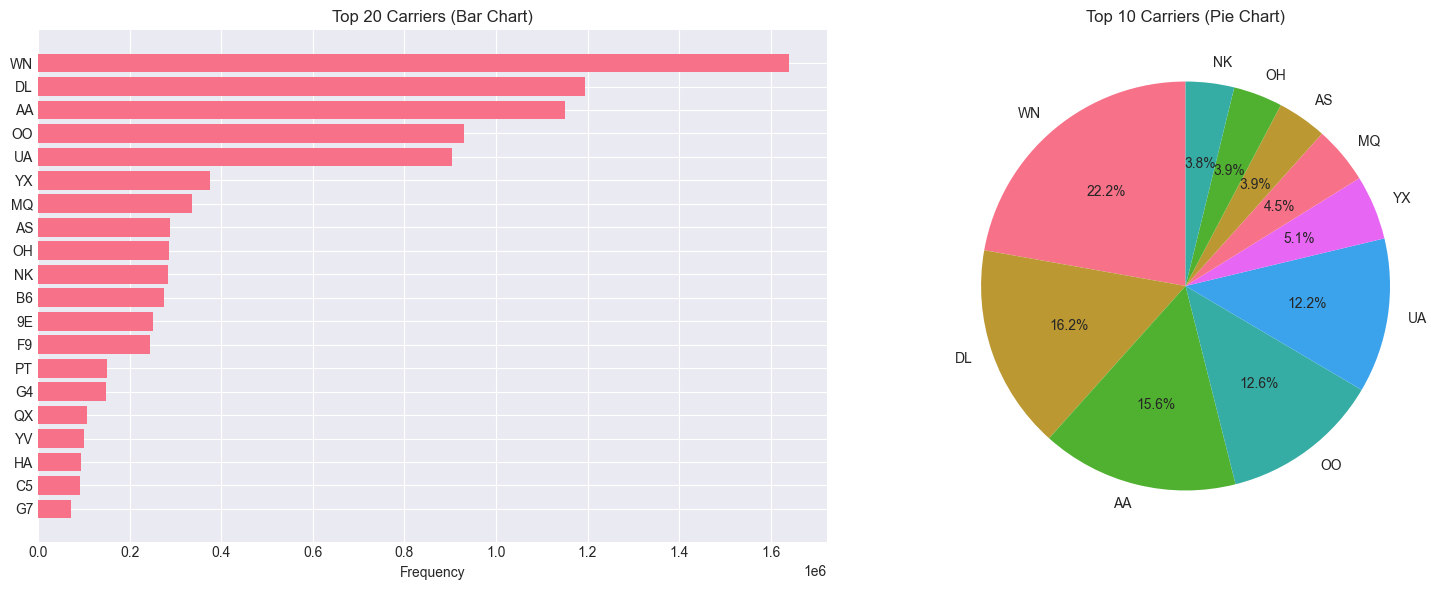

In [14]:
# Event type frequency
# This dataset does not have an 'event_type' column (it's airline on-time performance data),
# so we skip event-type analysis and instead look at a relevant categorical field, such as carrier.

if 'event_type' in df.columns:
    event_counts = df['event_type'].value_counts()

    print("Event Type Frequency:")
    print("="*60)
    print(event_counts)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart
    axes[0].barh(range(len(event_counts.head(20))), event_counts.head(20).values)
    axes[0].set_yticks(range(len(event_counts.head(20))))
    axes[0].set_yticklabels(event_counts.head(20).index)
    axes[0].set_xlabel('Frequency')
    axes[0].set_title('Top 20 Event Types (Bar Chart)')
    axes[0].invert_yaxis()

    # Pie chart (top 10)
    top_10 = event_counts.head(10)
    axes[1].pie(top_10.values, labels=top_10.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Top 10 Event Types (Pie Chart)')

    plt.tight_layout()
    plt.savefig(output_dir / 'event_type_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No 'event_type' column found; using 'OP_UNIQUE_CARRIER' as a proxy categorical variable.")
    if 'OP_UNIQUE_CARRIER' in df.columns:
        carrier_counts = df['OP_UNIQUE_CARRIER'].value_counts()

        print("Carrier Frequency:")
        print("="*60)
        print(carrier_counts)

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Bar chart for carriers
        axes[0].barh(range(len(carrier_counts.head(20))), carrier_counts.head(20).values)
        axes[0].set_yticks(range(len(carrier_counts.head(20))))
        axes[0].set_yticklabels(carrier_counts.head(20).index)
        axes[0].set_xlabel('Frequency')
        axes[0].set_title('Top 20 Carriers (Bar Chart)')
        axes[0].invert_yaxis()

        # Pie chart (top 10 carriers)
        top_10 = carrier_counts.head(10)
        axes[1].pie(top_10.values, labels=top_10.index, autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Top 10 Carriers (Pie Chart)')

        plt.tight_layout()
        plt.savefig(output_dir / 'carrier_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Neither 'event_type' nor 'OP_UNIQUE_CARRIER' columns are available; skipping this analysis.")


## Step 9: Altitude Distribution

Analyze altitude patterns and distributions.


In [20]:
# Altitude analysis
if 'altitude' in df.columns:
    altitude_data = df['altitude'].dropna()
    
    if len(altitude_data) > 0:
        print("Altitude Statistics:")
        print("="*60)
        print(altitude_data.describe())
        
        # Visualize
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Histogram
        axes[0, 0].hist(altitude_data / 1000, bins=50, edgecolor='black')
        axes[0, 0].set_xlabel('Altitude (km)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Altitude Distribution')
        
        # Box plot
        axes[0, 1].boxplot(altitude_data / 1000)
        axes[0, 1].set_ylabel('Altitude (km)')
        axes[0, 1].set_title('Altitude Box Plot')
        
        # Flight levels (common altitudes)
        flight_levels = [3000, 6000, 9000, 12000]  # meters
        for level in flight_levels:
            count = ((altitude_data >= level - 300) & (altitude_data <= level + 300)).sum()
            axes[1, 0].bar(level/1000, count, width=0.3, label=f'{level/1000}km')
        axes[1, 0].set_xlabel('Altitude (km)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Common Flight Levels')
        
        # Cumulative distribution
        axes[1, 1].hist(altitude_data / 1000, bins=50, cumulative=True, density=True, edgecolor='black')
        axes[1, 1].set_xlabel('Altitude (km)')
        axes[1, 1].set_ylabel('Cumulative Probability')
        axes[1, 1].set_title('Cumulative Altitude Distribution')
        
        plt.tight_layout()
        plt.savefig(output_dir / 'altitude_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("⚠️  No altitude data available")
else:
    print("⚠️  Altitude column not found")


⚠️  Altitude column not found


## Step 10: Temporal Patterns

Analyze temporal patterns (hourly, daily distributions).


In [21]:
# Temporal patterns
if 'timestamp' in df.columns:
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.day_name()
    df['date'] = df['timestamp'].dt.date
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Hourly distribution
    hourly_counts = df['hour'].value_counts().sort_index()
    axes[0, 0].bar(hourly_counts.index, hourly_counts.values)
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Event Count')
    axes[0, 0].set_title('Events by Hour of Day')
    axes[0, 0].set_xticks(range(0, 24, 2))
    
    # Daily distribution
    daily_counts = df['day_of_week'].value_counts()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_counts = daily_counts.reindex([d for d in day_order if d in daily_counts.index])
    axes[0, 1].bar(range(len(daily_counts)), daily_counts.values)
    axes[0, 1].set_xticks(range(len(daily_counts)))
    axes[0, 1].set_xticklabels(daily_counts.index, rotation=45, ha='right')
    axes[0, 1].set_ylabel('Event Count')
    axes[0, 1].set_title('Events by Day of Week')
    
    # Date distribution
    date_counts = df['date'].value_counts().sort_index()
    axes[1, 0].plot(date_counts.index, date_counts.values)
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Event Count')
    axes[1, 0].set_title('Events Over Time')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Hour vs Day heatmap
    hour_day = pd.crosstab(df['hour'], df['day_of_week'])
    sns.heatmap(hour_day, ax=axes[1, 1], cmap='YlOrRd', cbar_kws={'label': 'Event Count'})
    axes[1, 1].set_title('Events: Hour vs Day of Week')
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Hour of Day')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'temporal_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️  Timestamp column not available for temporal analysis")


⚠️  Timestamp column not available for temporal analysis


## Step 11: Parse Info Field

Extract and analyze information from the JSON info field.


In [22]:
# Parse info field
if 'info' in df.columns:
    print("Parsing info field...")
    df = extract_info_fields(df)
    
    # Analyze extracted fields
    if 'airport' in df.columns:
        airport_counts = df['airport'].value_counts().head(20)
        print("\nTop 20 Airports:")
        print(airport_counts)
        
        # Visualize
        plt.figure(figsize=(12, 6))
        airport_counts.plot(kind='barh')
        plt.xlabel('Event Count')
        plt.title('Top 20 Airports by Event Count')
        plt.tight_layout()
        plt.savefig(output_dir / 'airport_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    if 'runway' in df.columns:
        runway_counts = df['runway'].value_counts().head(20)
        print(f"\nTop 20 Runways: {len(runway_counts)} unique runways")
        print(runway_counts.head(10))
else:
    print("⚠️  Info column not found")


⚠️  Info column not found


## Step 12: Flight Reconstruction

Group events by flight_id and sort chronologically.


In [24]:
# Reconstruct flights (group by flight_id and sort by timestamp)
# The current dataset is airline on-time performance, with one row per flight and
# no explicit 'flight_id' or 'timestamp' columns. Therefore, true event-level
# reconstruction is not applicable. We create a proxy 'flight_id' and skip
# timestamp-based ordering if needed.

required_cols = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
available_required = [c for c in required_cols if c in df.columns]

if len(available_required) == len(required_cols):
    print("Reconstructing flights (using FL_DATE + CARRIER + ORIGIN + DEST as flight_id)...")

    # Create a proxy flight_id from available columns
    df_proxy = df.copy()
    df_proxy['flight_id'] = (
        df_proxy['FL_DATE'].astype(str) + '_' +
        df_proxy['OP_UNIQUE_CARRIER'].astype(str) + '_' +
        df_proxy['ORIGIN'].astype(str) + '_' +
        df_proxy['DEST'].astype(str)
    )

    # If no timestamp column exists, we skip temporal ordering and just sort by flight_id
    if 'timestamp' not in df_proxy.columns:
        df_sorted = df_proxy.sort_values(['flight_id']).reset_index(drop=True)
    else:
        df_sorted = reconstruct_flights(df_proxy)

    print("✓ Flights reconstructed (proxy flight_id)")
    print(f"Total records: {len(df_sorted):,}")
    print(f"Approx. unique flights: {df_sorted['flight_id'].nunique():,}")
else:
    print("Required columns for flight reconstruction (FL_DATE, OP_UNIQUE_CARRIER, ORIGIN, DEST) not all present.")
    print("Skipping flight reconstruction for this dataset.")
    df_sorted = df.copy()


Reconstructing flights (using FL_DATE + CARRIER + ORIGIN + DEST as flight_id)...
✓ Flights reconstructed (proxy flight_id)
Total records: 9,554,720
Approx. unique flights: 3,833,918


## Step 13: Flight Duration Analysis

Analyze flight durations and identify outliers.


In [26]:
# Create flight summary
print("Creating flight summary dataset...")

# If we have true event-level data with timestamps, use the full reconstruction
if 'flight_id' in df_sorted.columns and 'timestamp' in df_sorted.columns:
    flight_summary = create_flight_summary_dataset(df_sorted)
    print(f"✓ Flight summary created: {len(flight_summary):,} flights")
else:
    # For the airline on-time dataset (one row per flight, no timestamp),
    # create a simplified flight summary without durations.
    if 'flight_id' in df_sorted.columns:
        group_cols = ['flight_id']
        agg_dict = {}
        for col in ['FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'DEP_DELAY', 'ARR_DELAY']:
            if col in df_sorted.columns:
                # Use first value for identifiers, mean for delays/distance
                if col in ['DEP_DELAY', 'ARR_DELAY', 'DISTANCE']:
                    agg_dict[col] = 'mean'
                else:
                    agg_dict[col] = 'first'
        flight_summary = df_sorted.groupby(group_cols).agg(agg_dict).reset_index()
        print(f"✓ Basic flight summary created (no durations) for {len(flight_summary):,} flights")
    else:
        print("No 'flight_id' column available; using original data as flight summary.")
        flight_summary = df_sorted.copy()

# Analyze durations only if they exist
if 'duration_seconds' in flight_summary.columns:
    durations = flight_summary['duration_seconds'] / 3600  # Convert to hours
    
    print("\nFlight Duration Statistics:")
    print("="*60)
    print(f"Mean: {durations.mean():.2f} hours")
    print(f"Median: {durations.median():.2f} hours")
    print(f"Min: {durations.min():.2f} hours")
    print(f"Max: {durations.max():.2f} hours")
    print(f"Std: {durations.std():.2f} hours")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(durations, bins=50, edgecolor='black')
    axes[0].set_xlabel('Duration (hours)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Flight Duration Distribution')
    axes[0].axvline(durations.median(), color='r', linestyle='--', label=f'Median: {durations.median():.2f}h')
    axes[0].legend()
    
    # Box plot
    axes[1].boxplot(durations)
    axes[1].set_ylabel('Duration (hours)')
    axes[1].set_title('Flight Duration Box Plot')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'flight_duration_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Identify outliers (very short or very long flights)
    q1, q3 = durations.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers_short = durations[durations < (q1 - 1.5 * iqr)]
    outliers_long = durations[durations > (q3 + 1.5 * iqr)]
    
    print(f"\nOutliers:")
    print(f"  Very short flights (< {q1 - 1.5 * iqr:.2f}h): {len(outliers_short):,}")
    print(f"  Very long flights (> {q3 + 1.5 * iqr:.2f}h): {len(outliers_long):,}")
else:
    print("No 'duration_seconds' column in flight_summary; skipping duration analysis.")


Creating flight summary dataset...
✓ Basic flight summary created (no durations) for 3,833,918 flights
No 'duration_seconds' column in flight_summary; skipping duration analysis.


## Step 14: Events per Flight

Analyze the number of events per flight.


In [27]:
# Events per flight analysis
if 'n_events' in flight_summary.columns:
    events_per_flight = flight_summary['n_events']
    
    print("Events per Flight Statistics:")
    print("="*60)
    print(events_per_flight.describe())
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(events_per_flight, bins=50, edgecolor='black')
    axes[0].set_xlabel('Number of Events')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Events per Flight Distribution')
    axes[0].set_xlim(0, events_per_flight.quantile(0.99))
    
    # Box plot
    axes[1].boxplot(events_per_flight)
    axes[1].set_ylabel('Number of Events')
    axes[1].set_title('Events per Flight Box Plot')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'events_per_flight.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Identify sparse flights
    sparse_flights = flight_summary[flight_summary['n_events'] < 5]
    print(f"\nSparse flights (< 5 events): {len(sparse_flights):,}")


## Step 15: Geographic Distribution

Visualize the spatial distribution of flight events.


In [28]:
# Geographic distribution
if 'latitude' in df_sorted.columns and 'longitude' in df_sorted.columns:
    valid_coords = df_sorted[['latitude', 'longitude']].dropna()
    
    if len(valid_coords) > 0:
        # Sample for visualization (if too many points)
        sample_size = min(50000, len(valid_coords))
        coords_sample = valid_coords.sample(n=sample_size, random_state=42)
        
        plt.figure(figsize=(12, 8))
        plt.scatter(coords_sample['longitude'], coords_sample['latitude'], 
                   alpha=0.1, s=1, c='blue')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Geographic Distribution of Flight Events (Sample: {sample_size:,} points)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(output_dir / 'geographic_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nGeographic Coverage:")
        print(f"  Latitude range: {valid_coords['latitude'].min():.4f} to {valid_coords['latitude'].max():.4f}")
        print(f"  Longitude range: {valid_coords['longitude'].min():.4f} to {valid_coords['longitude'].max():.4f}")
    else:
        print("⚠️  No valid coordinates found")
else:
    print("⚠️  Coordinate columns not found")


⚠️  Coordinate columns not found


## Step 16: Summary Report

Generate a comprehensive summary of findings.


In [30]:
# Generate comprehensive quality report
# For very large datasets, computing full-DataFrame statistics (especially duplicates)
# can be memory intensive. We therefore compute the quality report on a sample.

sample_size = min(500_000, len(df_sorted))
print(f"Generating data quality report on a sample of {sample_size:,} records...")
df_sample = df_sorted.sample(n=sample_size, random_state=42) if len(df_sorted) > sample_size else df_sorted
quality_report = generate_quality_report(df_sample)

print("="*60)
print("DATA QUALITY SUMMARY REPORT")
print("="*60)

print(f"\n1. Dataset Overview:")
print(f"   - Total records (full dataset): {len(df_sorted):,}")
if 'flight_id' in df_sorted.columns:
    print(f"   - Approx. unique flights: {df_sorted['flight_id'].nunique():,}")
else:
    print("   - No explicit 'flight_id'; one row per flight assumed.")

# Date range: use timestamp if available, otherwise FL_DATE
if 'timestamp' in df_sorted.columns:
    print(f"   - Date range: {df_sorted['timestamp'].min()} to {df_sorted['timestamp'].max()}")
elif 'FL_DATE' in df_sorted.columns:
    print(f"   - Date range (FL_DATE): {df_sorted['FL_DATE'].min()} to {df_sorted['FL_DATE'].max()}")
else:
    print("   - Date range: not available")

if 'event_type' in df_sorted.columns:
    print(f"   - Event types: {df_sorted['event_type'].nunique()}")
else:
    print("   - No 'event_type' column in this dataset.")

print(f"\n2. Data Quality (based on sample of {sample_size:,} records):")
if quality_report['missing_values']:
    print(f"   - Missing values found in {len(quality_report['missing_values'])} columns")
if quality_report['duplicates']['n_duplicates'] > 0:
    print(f"   - Duplicates (sample): {quality_report['duplicates']['n_duplicates']:,}")

print(f"\n3. Flight Statistics:")
if 'duration_seconds' in flight_summary.columns:
    print(f"   - Mean duration: {flight_summary['duration_seconds'].mean() / 3600:.2f} hours")
    print(f"   - Median duration: {flight_summary['duration_seconds'].median() / 3600:.2f} hours")
if 'n_events' in flight_summary.columns:
    print(f"   - Mean events per flight: {flight_summary['n_events'].mean():.1f}")
    print(f"   - Median events per flight: {flight_summary['n_events'].median():.1f}")

print(f"\n4. Preliminary Anomalies Identified:")
if 'duration_seconds' in flight_summary.columns:
    durations = flight_summary['duration_seconds'] / 3600
    q1, q3 = durations.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = flight_summary[(durations < (q1 - 1.5 * iqr)) | (durations > (q3 + 1.5 * iqr))]
    print(f"   - Duration outliers: {len(outliers):,} flights")

if 'n_events' in flight_summary.columns:
    sparse = flight_summary[flight_summary['n_events'] < 5]
    print(f"   - Sparse flights (< 5 events): {len(sparse):,} flights")

print(f"\n5. Next Steps:")
print(f"   - Data is ready for Phase 2: Feature Engineering")
print(f"   - Processed data will be saved to: {processed_dir}")

print("\n" + "="*60)
print("PHASE 1 COMPLETE! ✓")
print("="*60)


Generating data quality report on a sample of 500,000 records...
DATA QUALITY SUMMARY REPORT

1. Dataset Overview:
   - Total records (full dataset): 9,554,720
   - Approx. unique flights: 3,833,918
   - Date range (FL_DATE): 1/1/2025 12:00:00 AM to 9/9/2024 12:00:00 AM
   - No 'event_type' column in this dataset.

2. Data Quality (based on sample of 500,000 records):
   - Missing values found in 29 columns

3. Flight Statistics:

4. Preliminary Anomalies Identified:

5. Next Steps:
   - Data is ready for Phase 2: Feature Engineering
   - Processed data will be saved to: c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed

PHASE 1 COMPLETE! ✓


## Step 17: Save Processed Data

Save cleaned and processed data for Phase 2.


In [31]:
# Save processed data
from src.data.data_loader import save_processed_data

# Save sorted events
events_output = processed_dir / 'events_sorted.csv.gz'
print(f"Saving sorted events to {events_output}...")
save_processed_data(df_sorted, str(events_output), compression='gzip')

# Save flight summary
summary_output = processed_dir / 'flight_summary.csv.gz'
print(f"Saving flight summary to {summary_output}...")
save_processed_data(flight_summary, str(summary_output), compression='gzip')

print("\n✓ Processed data saved successfully!")
print(f"  Events: {events_output}")
print(f"  Flight summary: {summary_output}")
print(f"\nReady for Phase 2: Feature Engineering!")


Saving sorted events to c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed\events_sorted.csv.gz...
Saving data to c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed\events_sorted.csv.gz...
✓ Saved 9,554,720 records
Saving flight summary to c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed\flight_summary.csv.gz...
Saving data to c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed\flight_summary.csv.gz...
✓ Saved 3,833,918 records

✓ Processed data saved successfully!
  Events: c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed\events_sorted.csv.gz
  Flight summary: c:\Users\aiish\OneDrive\Desktop\MSDA-SJSU\Fall 2025\Big Data\project\data\processed\flight_summary.csv.gz

Ready for Phase 2: Feature Engineering!
